_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens, Dr. Alexander Ecker

Tutors: Sarah Strauss, Santiago Cadena

Summer term 2019

Due date: 2019-07-09, 9am

Name: Shanqian Ma:{1,2,4} Weiyi Xiao:{3} 

# Exercise sheet 8

In this exercise we are going to fit a latent variable model (Poisson GPFA) to both toy data and real data from monkey primary visual cortex.

## Preliminaries

1. Clone the poisson-GPFA repository from https://github.com/mackelab/poisson-gpfa and make sure that you have a directory ```../funs/```  in the folder with this notebook. The toolbox contains an implementation of the EM algorithm to fit the poisson-gpfa. For the desciption of the algorithm please refer to https://hooram.xyz/projects.html 

2. Download the data file ```nda_ex_8_data.mat``` from ILIAS and save it in a subfolder ```../data/```.

In [1]:
import seaborn as sns
import funs.util as util
import funs.engine as engine
import matplotlib.pyplot as plt
import numpy as np
import datamanager
import scipy.io as sio
import numpy as np
import matplotlib.gridspec as gridspec
import pdb
import numpy.matlib
from statsmodels.stats.moment_helpers import cov2corr

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('paper')
sns.set(rc={'image.cmap': 'bwr'})
%matplotlib inline

## Task 1. Generate some toy data to test the poisson-GPFA code

We start by verifying our code on toy data. The cell below contains code to generate data for 30 neurons, 100 trials (1000 ms each) and 50ms bin size. The neurons' firing rate $\lambda_k$ is assumed to be a constant $d_k$ modulated by a one-dimensional latent state $x$, which is drawn from a Gaussian process:

$\lambda_k = \exp(c_kx + d_k)$

Each neuron's weight $c_k$ is drawn randomly from a normal distribution and spike counts are sampled form a Poisson distribution with rate $\lambda_k$.

Your task is to fit a Poisson GPFA model with one latent variable to this data (see `engine.PPGPFAfit`).

*Grading: 3 pts*

In [2]:
# Initialize random number generator
#np.random.seed(10)
# Specify dataset & fitting parameters
xdim      =1#latent dimensionality to fit
ydim      = 30		 #number of neurons in the dataset
numTrials = 100		
trialDur  = 1000 # in ms
binSize   = 50	 # in ms
maxEMiter = 100		
dOffset   = 1.5	 # controls firing rate

# Sample from the model (make a toy dataset)
training_set  = util.dataset(
    seed      =345533,
    xdim      = xdim,
	ydim      = ydim,
	numTrials = numTrials,
	trialDur  = trialDur,
	binSize   = binSize,
	dOffset   = dOffset,
	fixTau 	  = True, 
	fixedTau  = np.array([0.2]),
	drawSameX = False) 

+------------- Simulated Dataset Options -------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                 1000 | Duration of trials (ms):
                                                   50 | Size of bins (ms):
                                                  100 | Number of Trials
+-----------------------------------------------------+
Sampling trial 100 ...
Average firing rate per neuron in this dataset: 46.415 Hz.


### Fit the model

In [3]:
# Initialize parameters using Poisson-PCA
initParams = util.initializeParams(xdim, ydim, training_set)

# fit the model
fitToy = engine.PPGPFAfit(training_set,initParams,xdim=1,EMmode= 'Batch',maxEMiter=maxEMiter)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   30 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = 13.7859
This dataset is a simulated dataset.
Processing performance against ground truth parameters...


In [4]:
help(engine.PPGPFAfit)

Help on class PPGPFAfit in module engine:

class PPGPFAfit(builtins.object)
 |  PPGPFAfit(experiment, initParams=None, xdim=2, inferenceMethod='laplace', maxEMiter=50, optimLogLamb=False, CdOptimMethod='TNC', tauOptimMethod='TNC', verbose=False, EMmode='Online', batchSize=5, onlineParamUpdateMethod='diag', hessTol=None, stepPow=0.75, updateCdJointly=True, fullyUpdateTau=False, extractAllTraj=False, extractAllTraj_trueParams=False, getPredictionErr=False, CdMaxIter=None, tauMaxIter=None)
 |  
 |  Poisson-GPFA model fit given a neural population spike data. 
 |  
 |  Input Attributes:
 |  =================
 |    * experiment : (util.dataset object), required
 |      - A dataset object with the following attributes:
 |          experiment.data     - A list of dictionaries in the following format:
 |            experiment.data[trial]['Y'] - numpy array of shape (#time bins, # neurons)
 |          experiment.T        - number of time bins, all trials must have the same length
 |          ex

In [5]:
#some useful functions
def allTrialsState(fit,p):
    """Reshape the latent signal and the spike counts"""
    x = np.zeros([p,0])
    for i in range(len(fit.infRes['post_mean'])):
        x = np.concatenate((x,fit.infRes['post_mean'][i]),axis=1) # weird! only have 5 trials
    return x

def getOriginalX(training_set):
    """Reshape the ground truth 
    latent signal and the spike counts"""
    x_gt = np.array([])
    for i in range(len(training_set.data)):
        x_gt =  np.concatenate((x_gt,training_set.data[i]['X'][0]),axis = 0) # 20 bins for neuron 0
    return x_gt

In [6]:
help(util.dataset)

Help on class dataset in module funs.util:

class dataset(builtins.object)
 |  dataset(trialDur=1000, binSize=10, drawSameX=False, numTrials=20, xdim=3, ydim=30, seed=12, dOffset=-1, fixTau=False, fixedTau=None, params=None, model='pgpfa')
 |  
 |  Dataset containing multiple trials of population spike counts. A dataset is sampled from the
 |  Poisson-GPFA model as described by the equations
 |      
 |      x ~ GP(0,K(tau))            - (1)
 |      y ~ Poisson(exp(Cx+d))      - (2)
 |  
 |  Attributes:
 |  ===========
 |    * self.xdim : int, latent dimensionality.
 |    * self.ydim : int, number of neurons.
 |    * self.data : list of dictionaries
 |          The nth element of the list is a dictionary containing the data such that
 |        - self.data[n]['X'] : numpy array of shape (xdim x T)
 |              The true latent trajectory of trial n
 |        - self.data[n]['Y'] : numpy array of shape (ydim x T)
 |              The spike counts of the population of trial n
 |    * self

### Plot the ground truth vs. inferred model
Verify your fit by plotting both ground truth and inferred parameters for:
1. weights C
2. biases d
3. spike counts covariance matrix
4. latent state x 

Note that the sign of fitted latent state and its weights are ambiguous (you can flip both without changing the model). Make sure you correct the sign for the plot if it does not match the ground truth.

##### 1.weights C; 2.biases d

Text(0.5, 1.0, 'Biases d')

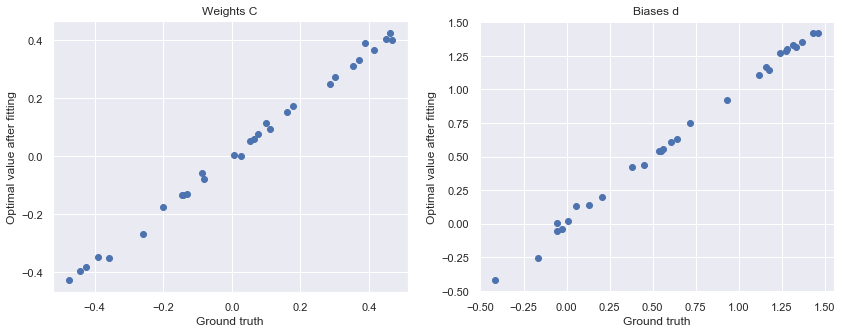

In [7]:
## ground truth for C, d
C_true=training_set.params['C'] # special for each neuron
d_true=training_set.params['d'] # special for each neuron (30,1)

## fitted optimal C, d
C_opt = fitToy.optimParams['C']
d_opt = fitToy.optimParams['d']

plt.figure(figsize=([14,5]))
plt.subplot(1,2,1)
plt.plot(C_true,-C_opt,'o')
plt.xlabel('Ground truth')
plt.ylabel('Optimal value after fitting')
plt.title('Weights C')

plt.subplot(1,2,2)
plt.plot(d_true,d_opt,'o')
plt.xlabel('Ground truth')
plt.ylabel('Optimal value after fitting')
plt.title('Biases d')

##### 3. Spike counts covariance matrix

In [8]:
def colorBarRange(matrix):
    low = np.min(matrix)
    high = np.max(matrix)
    limit = np.max([np.abs(low),np.abs(high)])
    return limit

Text(0.5, 1.0, 'Estimated spike count covariance')

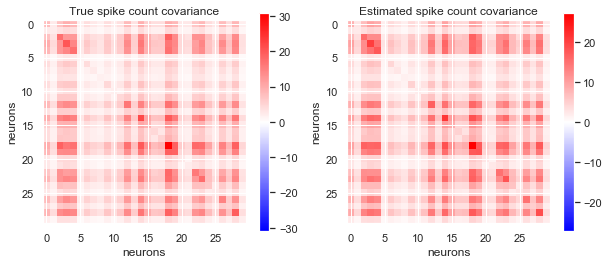

In [9]:
spkcov_true=fitToy.E_yy_true_params # true spike count covariance
spkcov_opt=fitToy.E_yy_optim_params # optimal spike count covariance

plt.figure(figsize=([10,4]))
plt.subplot(1,2,1) 
limit = colorBarRange(spkcov_true)
plt.imshow(spkcov_true,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("True spike count covariance")
plt.subplot(1,2,2) 
limit = colorBarRange(spkcov_opt)
plt.imshow(spkcov_opt,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("Estimated spike count covariance")

##### 4. Latent state x

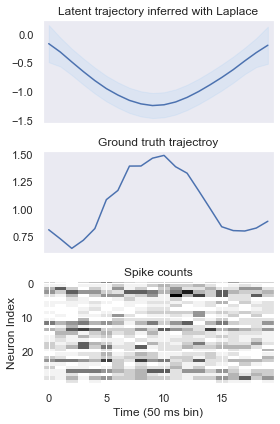

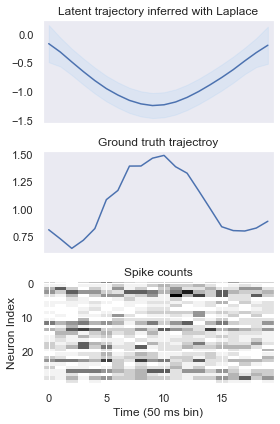

In [10]:
# example trial state trajectory using function inside "engine"
fitToy.plotTrajectory(0) # trial 0

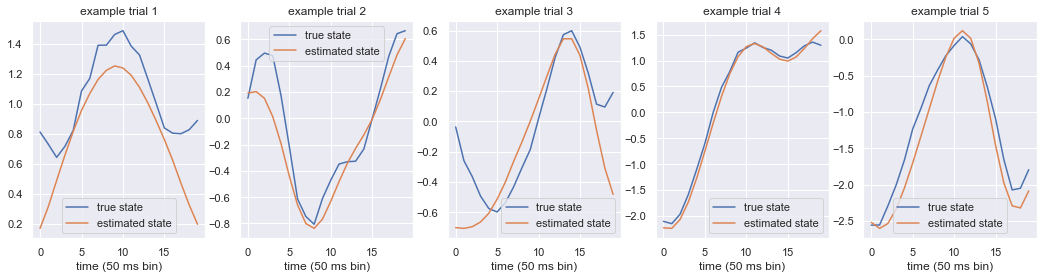

In [32]:
## groud truth for latent state

'''Note: latent state is different for each neuron even in same trial'''
x_true = getOriginalX(training_set) 
# Note: 
# (2000,1) each trial have 20 bins * 100 trials; [0:20] is first trial
# the function "getOriginalX" only extract state for neuron 0
# use average state of 20bins for 100 trials as below:

x_opt = allTrialsState(fitToy,1).flatten()
#(100,1)# only 1 state for each trial or only 5 trials data

# plot 
plt.figure(figsize=([18,4]))
for i in range(5):
    plt.subplot(1,5,i+1)  
    plt.plot(x_true[i*20:(i+1)*20],label='true state')
    plt.plot(-x_opt[i*20:(i+1)*20],label='estimated state')
    plt.title('example trial '+str(i+1))
    plt.xlabel('time (50 ms bin)')
    plt.legend()

## Task 2: Fit GPFA model to real data. 

We now fit the model to real data and cross-validate over the dimensionality of the latent variable.

*Grading: 2 pts*



### Load data

The cell below implements loading the data and encapsulates it into a class that matches the interface of the Poisson GPFA engine. You don't need to do anything here.

In [12]:
class EckerDataset():
    """Loosy class"""
    def __init__(
        self,
        path = 'data/task8_data.mat',
        subject_id=0,
        ydim = 55,
        trialDur = 400,
        binSize = 20,
        numTrials = 100,
        ydimData = False,
        numTrData = True):
        
        T = binSize#int(trialDur/binSize)
        matdat = sio.loadmat(path)
        self.matdat = matdat
        data = []
        trial_durs = []
        for trial_id in range(numTrials):
            trial_time =matdat['spikeTimes'][:,trial_id][0] 
            trial_big_time = np.min(trial_time)
            trial_end_time = np.max(trial_time)
            trial_durs.append(trial_end_time - trial_big_time)         
        for trial_id in range(numTrials):
            Y = []
            spike_time = []
            data.append({
                'Y': matdat['spikeCounts'][:,:,trial_id],
                'spike_time': matdat['spikeTimes'][:,trial_id]})
        self.T = T
        self.trial_durs = trial_durs    
        self.data = data
        self.trialDur = trialDur
        self.binSize = binSize
        self.numTrials = numTrials
        self.ydim = ydim              
        util.dataset.getMeanAndVariance(self)
        util.dataset.getAvgFiringRate(self)
        util.dataset.getAllRaster(self)

In [13]:
path = 'data/nda_ex_8_data.mat'
data = EckerDataset(path)

### Fit Poisson GPFA models and perform model comparison

Split the data into 80 trials used for training and 20 trials held out for performing model comparison. On the training set, fit models using one to five latent variables. Compute the performance of each model on the held-out test set.

Hint: You can use the `crossValidation` function in the Poisson GPFA package.

Optional: The `crossValidation` function computes the mean-squared error on the test set, which is not ideal. The predictive log-likelihood under the Poisson model would be a better measure, which you are welcome to compute instead.

In [14]:
help(util.crossValidation)

Help on class crossValidation in module funs.util:

class crossValidation(builtins.object)
 |  crossValidation(experiment, numTrainingTrials=10, numTestTrials=2, maxXdim=6, maxEMiter=3, batchSize=5, inferenceMethod='laplace', learningMethod='batch')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, experiment, numTrainingTrials=10, numTestTrials=2, maxXdim=6, maxEMiter=3, batchSize=5, inferenceMethod='laplace', learningMethod='batch')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  plotPredictionError(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [15]:
crossValid_fit=util.crossValidation(experiment=data,numTrainingTrials=80, numTestTrials=20, maxXdim=5, maxEMiter=25) # at most 5 latent variable

Assessing optimal latent dimensionality will take a long time.
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                   25 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration:  25 of  25, nPLL: = -391.7422Performing leave-one-out cross validation...
Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    2 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
         

### Plot the test error

Make a plot of the test error for the five different models. As a baseline, please also include the test error of a model without a latent variable. This is essentially the mean-squared error of a constant rate model (or Poisson likelihood if you did the optional part above).

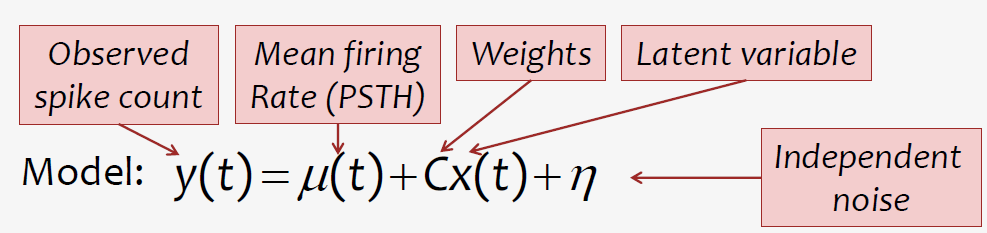

##### Based on the above formula from lecture, we can get mean firing rate from training set as $\mu$ and then compare this with the data in test set

In [16]:
# To calculate the mean square error for baseline

train_set, test_set = util.splitTrainingTestDataset(data,numTrainingTrials=80,numTestTrials=20)

train_spike=[] # combine the 80 trials
for tr in range(train_set.numTrials):
    train_spike.append(train_set.data[tr]['Y'])

mu=np.mean(train_spike,axis=0) # average of training set; still (55,20)

error=0
for tr in range(test_set.numTrials):
    for n in range(test_set.ydim):
        # Modified from util.leaveOneOutPrediction function
        error = error + np.dot(test_set.data[tr]['Y'][n]-mu[n,:],test_set.data[tr]['Y'][n]-mu[n,:])
        # Note: since the function is sum square error, here need to be consistent instead of mean square error

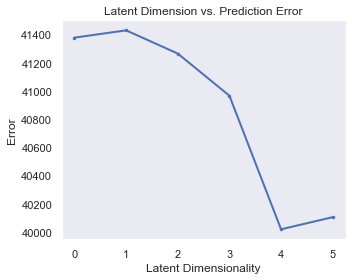

In [17]:
# To plot the crossValidation error
error_with_baseline=crossValid_fit.errs 
error_with_baseline.insert(0, error) # add the baseline error to crossValidation error
plt.figure(figsize=(5,4))
plt.plot(np.arange(0,crossValid_fit.maxXdim+1),error_with_baseline,'b.-',markersize=5,linewidth=2)
plt.xlabel('Latent Dimensionality')
plt.ylabel('Error')
plt.title('Latent Dimension vs. Prediction Error')
plt.grid(which='both')
plt.tight_layout()

## Task 3. Visualization: population rasters and latent state. Use the model with a single latent state. 

Create a raster plot where you show for each trial the spikes of all neurons as well as the trajectory of the latent state `x`. Sort the neurons by their weights `c_k`. Plot only the first 20 trials.

*Grading: 2 pts*

In [18]:
# Initialize parameters using Poisson-PCA
data.xdim=1
initParams = util.initializeParams(data.xdim, data.ydim, data)

# fit the model, LS_1: single latent state
maxEMiter=100
fit_LS_1 = engine.PPGPFAfit(data,initParams,xdim=1,EMmode = 'Batch',maxEMiter=maxEMiter)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    1 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -379.4044

In [19]:
c_k=fit_LS_1.optimParams['C'].flatten()     # fits[0]: model fit with one latent state while cross validation
sorted_ck_idx = np.argsort(c_k)

In [20]:
latent_trajectory = fit_LS_1.infRes['post_mean']

In [21]:
def raster_trajectory_plot(trial_idx):
    test = data.data[trial_idx]['spike_time'][sorted_ck_idx]
    t = np.linspace(0.5*data.binSize,data.trialDur-0.5*data.binSize,int(data.trialDur/data.binSize))
    plt.plot(t,latent_trajectory[trial_idx].squeeze()*3)  # use a scaling factor to make the change in trajectory more visible.
    c=0
    for i in range(55):
        plt.vlines(test[i],c,c+1,lw=1)
        c+=1
        plt.xlim(-400,800)
    plt.xlabel('time [ms]')
    plt.ylabel('neurons')
    plt.title('trial #'+str(trial_idx+1))
    plt.yticks([])

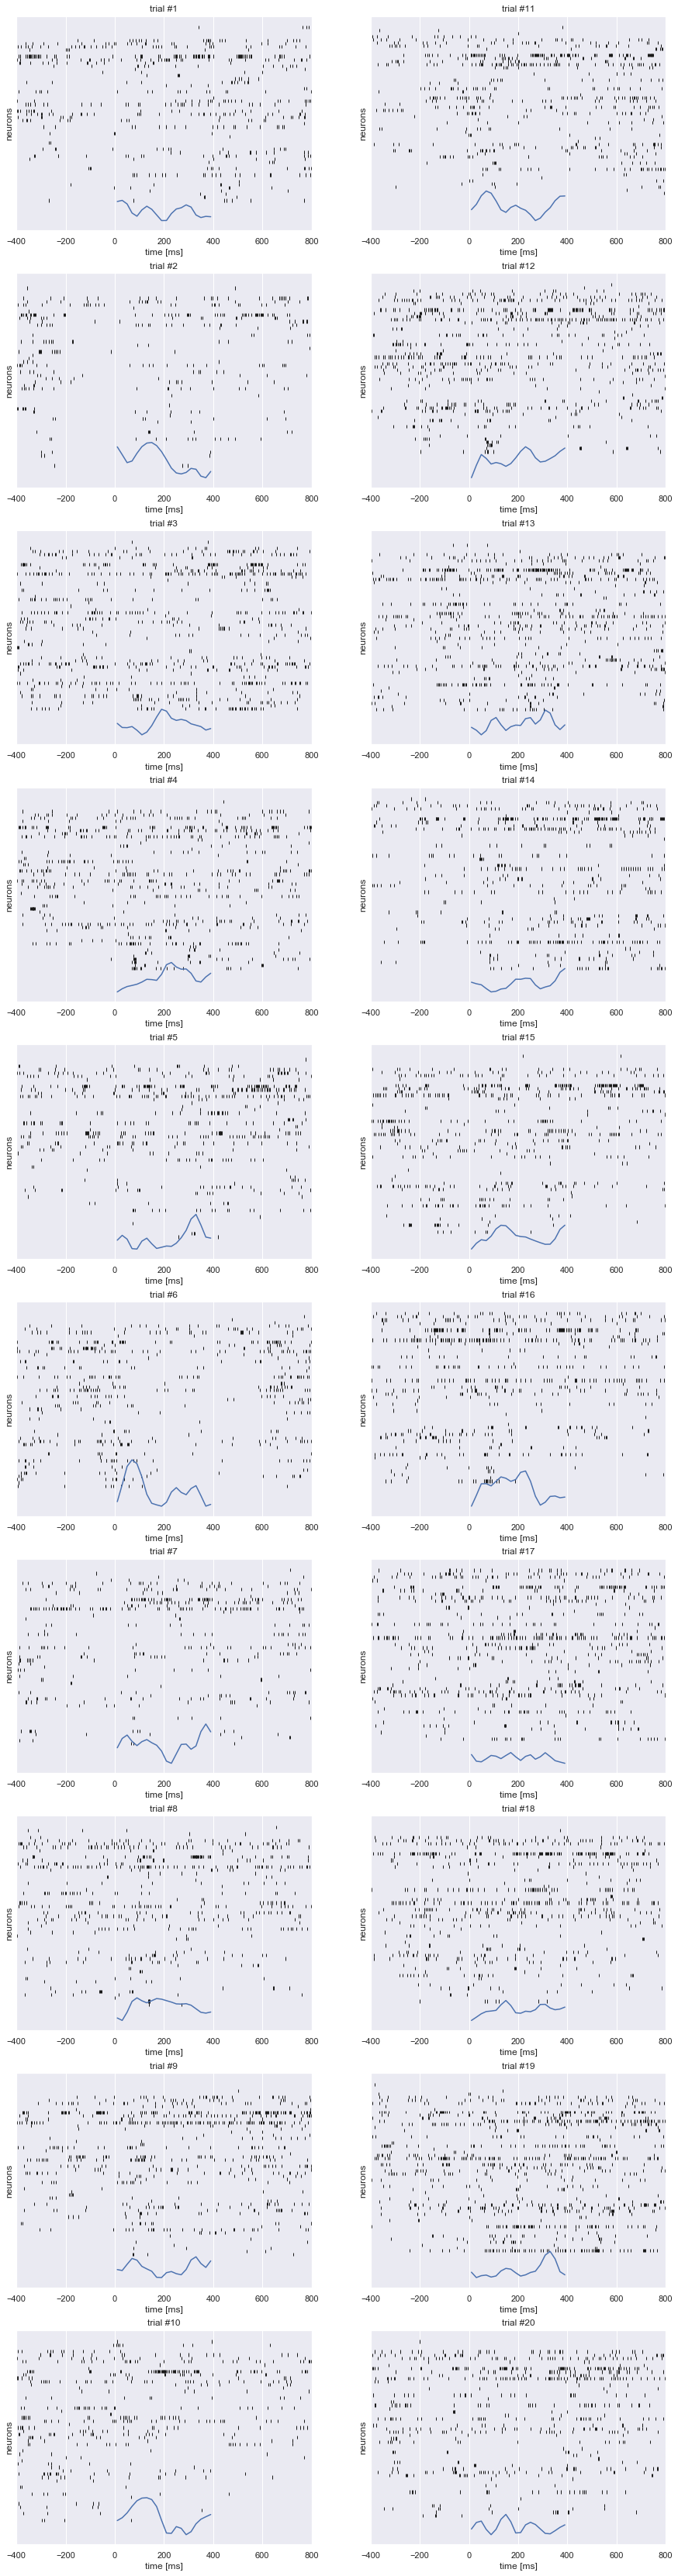

In [22]:
plt.figure(figsize=(15, 60))
plt_idx = np.arange(20)
plt_idx = np.reshape(plt_idx,(2,10))
for i in range(20):
    plt.subplot(10,2,i+1)
    raster_trajectory_plot(trial_idx=plt_idx[i%2,int(i/2)])
    

## Task 4. Visualization of covariance matrix.

Plot (a) the noise covariance matrix as well as its approximation using (b) one and (c) five latent variable(s). Use the analytical solution for the covariance matrix of the approximation*. Note that the solution is essentially the mean and covariance of the [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

$ \mu = \exp(\frac{1}{2} \text{ diag}(CC^T)+d)$

$ \text{Cov}= \mu\mu^T \exp(CC^T)+\text{ diag}(\mu) - \mu\mu^T$ 

*[Krumin, M., and Shoham, S. (2009). Generation of Spike Trains with Controlled Auto- and Cross-Correlation Functions. Neural Computation 21, 1642–1664](http://www.mitpressjournals.org/doi/10.1162/neco.2009.08-08-847).

*Grading: 3 pts*

In [23]:
# Initialize parameters using Poisson-PCA
data.xdim=5
initParams = util.initializeParams(data.xdim, data.ydim, data)

# fit the model, LS_1: single latent state
maxEMiter=100
fit_LS_5 = engine.PPGPFAfit(data,initParams,EMmode = 'Batch',maxEMiter=maxEMiter)

Initializing parameters with Poisson-PCA..
+-------------------- Fit Options --------------------+
                                                    5 | Dimensionality of Latent State
                                                   55 | Dimensionality of Observed State (# neurons)
                                                Batch | EM mode:
                                                  100 | Max EM iterations:
                                              laplace | Inference Method
+-----------------------------------------------------+
Iteration: 100 of 100, nPLL: = -310.2041

##### (a) Noise covariance matrix of true data and model estimations

In [24]:
# your plot here
# Get fitting results from crossValidation
noise_cov = fit_LS_1.E_yy_obs # covariance for true/observed data
noise_cov__1 = fit_LS_1.E_yy_optim_params
noise_cov__5 = fit_LS_5.E_yy_optim_params

Text(0.5, 1.0, 'Model estimated covariance with five latent variable')

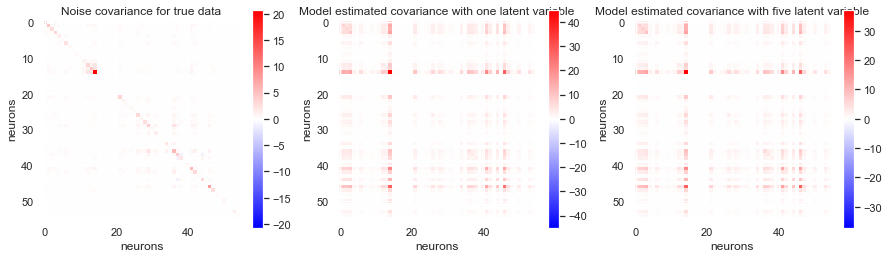

In [25]:
plt.figure(figsize=([15,4]))

plt.subplot(1,3,1) 
limit = colorBarRange(noise_cov)
plt.imshow(noise_cov,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("Noise covariance for true data")

plt.subplot(1,3,2) 
limit = colorBarRange(noise_cov__1)
plt.imshow(noise_cov__1,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("Model estimated covariance with one latent variable")

plt.subplot(1,3,3) 
limit = colorBarRange(noise_cov__5)
plt.imshow(noise_cov__5,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("Model estimated covariance with five latent variable")


##### (b)(c) Approximated covariance with one and five latent variable using analytical solution

In [29]:
def mu(C,d):
    output = np.exp((1/2)*np.diag(np.matmul(C,C.T))+d) # mu(55,)
    return output

def noise_cov_approximation(C,d):
    m = mu(C,d)
    output = np.outer(m,m) * np.exp(np.matmul(C,C.T)) + np.diag(m)  - np.outer(m,m) # np.outer(m,m)=np.outer(m,m.T)
    return output

In [30]:
# Get optimal parameters C and d from two fitting
C_1_x=fit_LS_1.optimParams['C']
d_1_x=fit_LS_1.optimParams['d']
C_5_x=fit_LS_5.optimParams['C']
d_5_x=fit_LS_5.optimParams['d']

# Calculate approximation covariance using given analyticla solution
noise_cov_1_x=noise_cov_approximation(C_1_x,d_1_x)
noise_cov_5_x=noise_cov_approximation(C_5_x,d_5_x)

Text(0.5, 1.0, 'Noise covariance with five latent variable')

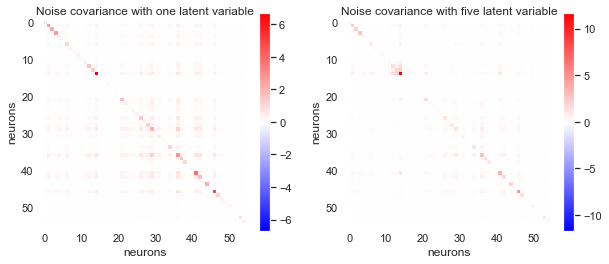

In [31]:
# plot
plt.figure(figsize=([10,4]))

plt.subplot(1,2,1) 
limit = colorBarRange(noise_cov_1_x)
plt.imshow(noise_cov_1_x,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("Noise covariance with one latent variable")

plt.subplot(1,2,2) 
limit = colorBarRange(noise_cov_5_x)
plt.imshow(noise_cov_5_x,vmin=-limit,vmax=limit)
plt.colorbar()
plt.xlabel('neurons')
plt.ylabel('neurons')
plt.title("Noise covariance with five latent variable")